<a href="https://colab.research.google.com/github/ChuLinh02/DeepLearning/blob/main/21120496.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-channel LSTM-CNN Model for Text Classification**

**Name**: Chu Hải Linh

**MSSV**: 21120496

**Class**: Deep Learning - CQ2021/24

### **Import necessary Libraries**

I will use **TensorFlow** for model creation and preprocessing, and **scikit-learn** for evaluation.

In [1]:
# import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## **Step 1: Load Dataset**

I use the **IMDb dataset**, which contains 25,000 movie reviews labeled as positive or negative.

This dataset is pre-tokenized and can be loaded directly using TensorFlow.

In [2]:
from tensorflow.keras.datasets import imdb

print("Loading data...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# Print dataset info
print("Number of training samples:", len(x_train))
print("Number of testing samples:", len(x_test))

Loading data...
Number of training samples: 25000
Number of testing samples: 25000


## **Step 2: Preprocess the Data**

To prepare the dataset for the model, I:

* Pad sequences to ensure uniform length.

* Define a maximum sequence length (`maxlen`)


In [3]:
print("Preprocessing data...")

# Define a maximum sequence length
maxlen = 200

# Pad sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Check the sizes of the new splits
print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Testing set size: {len(x_test)}")

Preprocessing data...
Training set size: 20000
Validation set size: 5000
Testing set size: 25000


## **Step 3: Build the Multi-channel LSTM-CNN Model**

I create two branches:

* **LSTM Branch**: for capturing sequential dependencies.

* **CNN Branch**: for capturing local patterns (n-grams).

These are combined using a `Concatenate` layer, followed by full connected layers for classification.

In [4]:
print("Building model...")

# Input layer
input_layer = Input(shape=(maxlen,))

# Embedding layer
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=maxlen)(input_layer)

# LSTM branch
lstm_output= LSTM(128)(embedding_layer)

# CNN branch
conv_output = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding_layer)
conv_output = MaxPooling1D(pool_size=2)(conv_output)
conv_output = Flatten()(conv_output)

# Concatenate LSTM and CNN features
merged = Concatenate()([lstm_output, conv_output])
dropout = Dropout(0.7)(merged)
dense = Dense(64, activation='relu')(dropout)
output_layer = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Building model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 128)       │      1,280,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 198, 128)       │         49,280 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 99, 128)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │        131,584 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12672)          │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 12800)          │              0 │ lstm[0][0],            │
│                           │                        │                │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 12800)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        819,264 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,280,193 (8.70 MB)

 Trainable params: 2,280,193 (8.70 MB)

 Non-trainable params: 0 (0.00 B)

## **Step 4: Compile and train the model**

I use the Adam optimizer and binary crossentropy loss function for binary classification.

The model is trained for 5 epochs.

In [5]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training model...")

# Define callbacks for EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Training model
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint]# Prevent overfitting
)

Training model...
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5347 - loss: 0.6748 - val_accuracy: 0.8642 - val_loss: 0.3199
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8866 - loss: 0.2777 - val_accuracy: 0.8690 - val_loss: 0.3087
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9351 - loss: 0.1727 - val_accuracy: 0.8844 - val_loss: 0.2931
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9605 - loss: 0.1167 - val_accuracy: 0.8706 - val_loss: 0.3589
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9736 - loss: 0.0804 - val_accuracy: 0.8686 - val_loss: 0.4142


## **Step 5: Evaluate the model**

I use the test set to evaluate the model and generate a classification report

In [6]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Print the results in percentage format
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss * 100:.2f}%")


782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     12500
           1       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

782/782 - 3s - 4ms/step - accuracy: 0.8707 - loss: 0.3208
Test Accuracy: 87.07%
Test Loss: 32.08%


## **Display prediction results**

In [7]:
# Display some examples from the test dataset
index_to_word = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in index_to_word.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '') for i in text if reverse_word_index.get(i - 3)])

# Select 5 random samples to display
import numpy as np
sample_indices = np.random.choice(len(x_test), size=5, replace=False)

for i in sample_indices:
    review = decode_review(x_test[i])
    print(f"Review: {review}")
    print(f"Actual Label: {'Positive' if y_test[i] == 1 else 'Negative'}")
    print(f"Predicted Label: {'Positive' if y_pred[i] == 1 else 'Negative'}")
    print("-"*80)


Review: this was a movie that at the end i thought now that was an enjoyable 2 hours i hate spending around 20 not including baby sitting for my husband and myself to have that it was ok feeling br br i think i like will smith better as a comedic actor than an action hero he was well cast in this his character was very likable as was kevin br br there were several laugh out loud scenes it's also a romantic movie so guys if you want to impress the lady in your life take her to this women will like it as much as any chick flick but i wouldn't this as one there is plenty of guy humor in it for men to enjoy i think that's one of the reasons why this movie is so perfect as a date movie it has romance and slapstick i don't usually like slapstick that much but it wasn't overdone and i can't think of any those scenes that didn't deliver laughs br br i definitely recommend this movie the first thing my husband said to me after it was over was i want to see it again
Actual Label: Positive
Predic

## **Plot loss and accuracy**

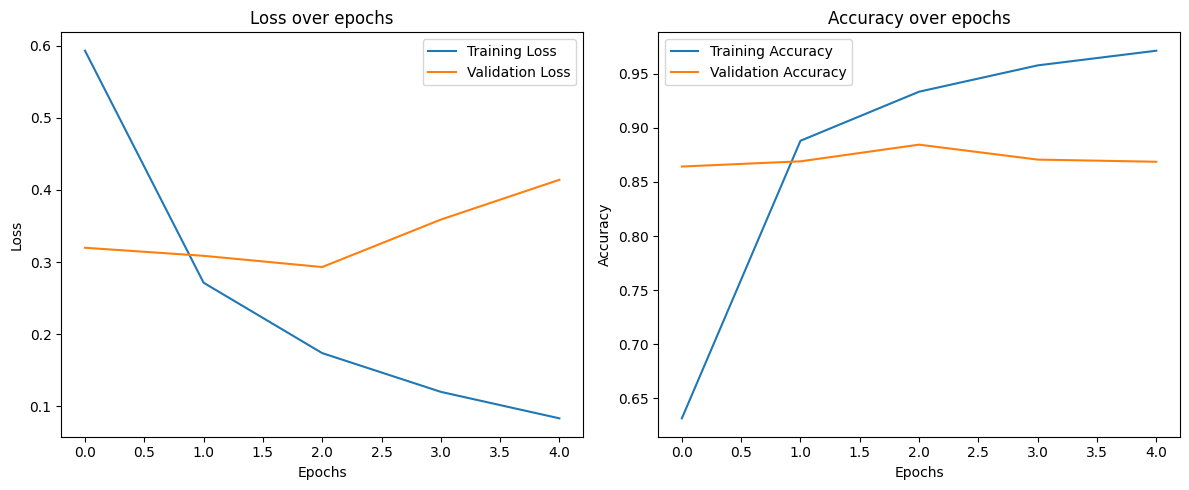

In [8]:
import matplotlib.pyplot as plt

# Create a figure with subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss Plot (Left)
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss over epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Accuracy Plot (Right)
ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy over epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


**Observations:**

**1. Loss over Epochs (Left Chart):**

- ***The training loss*** decreases steadily over epochs, showing that the model is learning the training data well.

- ***The validation loss***, however, increases after the first epoch. This is a clear indication of overfitting—the model performs well on the training data but fails to generalize to unseen data.

**2. Accuracy over Epochs (Right Chart):**

- ***The training accuracy*** increases consistently over epochs, aligning with the reduction in training loss.

- ***The validation accuracy*** plateaus after the first epoch and slightly decreases in subsequent epochs, further confirming that the model struggles to generalize to the validation set.


## **Testing with custom data**

In this section, we test the model with custom reviews that are not part of the dataset. The goal is to evaluate how the model performs on unseen data and analyze its predictions. Below are the steps performed:

### 1. Define custom reviews
- A list of reviews is created manually. These reviews include both positive and negative sentiments to check how well the model generalizes to new data.
- Examples include:
  - Highly positive reviews (e.g., *\"The movie was absolutely fantastic with a brilliant storyline."*).
  - Strongly negative reviews (e.g., *\"I hated this film; it was a complete waste of time."*).
  - Neutral or mixed reviews (e.g., *\"The plot was okay, but the characters were not very compelling."*).

### 2. Preprocess reviews
- The reviews are tokenized into word indices based on the IMDb vocabulary.
- Words not found in the vocabulary are replaced with a special token.
- The tokenized reviews are then padded to match the input length expected by the model (e.g., 200 tokens).

### 3. Predict sentiment
- The processed reviews are fed into the trained model for predictions.
- The model outputs:
  - A **confidence score**: How confident the model is in its prediction.
  - A **sentiment label**: Either *Positive* or *Negative* based on the confidence score.

### 4. Display results
- Each review is displayed alongside:
  - Its text content.
  - The predicted sentiment (*Positive* or *Negative*).
  - The confidence score (a value between 0 and 1).

### Example output
```text
Review: The movie was absolutely fantastic with a brilliant storyline.
Predicted Sentiment: Positive (Confidence: 0.95)
--------------------------------------------------------------------------------
Review: I hated this film; it was a complete waste of time.
Predicted Sentiment: Negative (Confidence: 0.89)



In [9]:
# Function to preprocess and predict sentiment for custom reviews
def preprocess_and_predict(review, tokenizer, maxlen, model):
    # Tokenize the input review
    tokens = [tokenizer.get(word, 2) + 3 for word in review.split()]
    tokens = pad_sequences([tokens], maxlen=maxlen, padding='post')

    # Predict sentiment
    prediction = model.predict(tokens)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"

    # Display results
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment} (Confidence: {prediction:.2f})")
    print("-"*80)

    return sentiment, prediction

In [10]:
# Example custom reviews for testing
custom_revews = [
    "The movie was absolutely fantastic with a brilliant storyline.",
    "I hated this film; it was a complete waste of time.",
    "The plot was okay, but the characters were not very compelling.",
    "What an amazing performance by the lead actor!",
    "This movie was just boring. I fell asleep halfway through."
]

# Create a tokenizer mapping from IMDb dataset (like `index_to_word`)
index_to_word = imdb.get_word_index()
word_to_index = {key: value for key, value in index_to_word.items()}

# Test custom reviews
for review in custom_revews:
    preprocess_and_predict(review, word_to_index, maxlen, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Review: The movie was absolutely fantastic with a brilliant storyline.
Sentiment: Positive (Confidence: 0.70)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Review: I hated this film; it was a complete waste of time.
Sentiment: Negative (Confidence: 0.19)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Review: The plot was okay, but the characters were not very compelling.
Sentiment: Negative (Confidence: 0.43)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Review: What an amazing performance by the lead actor!
Sentiment: Positive (Confidence: 0.62)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Review: This movie was just boring. I fell asleep halfway through.
Senti